In [2]:
#Conexió al Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

EVO_pinn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/data_EVO/EVO.csv')

In [4]:
EVO_pinn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61368 entries, 0 to 61367
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dia               61368 non-null  object 
 1   Tm                61355 non-null  float64
 2   Tmax              61363 non-null  float64
 3   Tmin              61364 non-null  float64
 4   Velocitat_vent    61368 non-null  float64
 5   HRmd              61356 non-null  float64
 6   HRmax             61363 non-null  float64
 7   Precipitacio      61368 non-null  float64
 8   Irradiacio_solar  61361 non-null  float64
 9   ETo               61216 non-null  float64
 10  Clima             61368 non-null  object 
 11  Lat               61368 non-null  float64
 12  EMA               61368 non-null  object 
 13  Any               61368 non-null  int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 6.6+ MB


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import tensorflow as tf
import os
import random

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

df = EVO_pinn

# Filtratge per només un tipus de clima
# Mateix model que el treball de Marroc
# Dades separades per EMA i sense variables categoriques

df = df[df['Clima'] == 'LM'].copy()

# Eliminació nulls seguretat
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df['Dia'] = pd.to_datetime(df['Dia'])
df['D'] = df['Dia'].dt.dayofyear


# Creació variable dia en ciclica
df['Dia_sin'] = np.sin(2 * np.pi * df['D'] / 365.0)
df['Dia_cos'] = np.cos(2 * np.pi * df['D'] / 365.0)


# Codificació varaible categorica tipus de clima
le_clima = LabelEncoder()
df['Clima_enc'] = le_clima.fit_transform(df['Clima'])
num_classes_clima = len(np.unique(df['Clima_enc']))

# Conjunts variables i variable objectiu
X_num = df[['Tmax', 'Irradiacio_solar']].values
X_clima = df['Clima_enc'].values
y = df['ETo'].values
temp = df['Tm'].values

# Divisió entrenament/test
X_num_train, X_num_test, X_clima_train, X_clima_test, temp_train, temp_test, y_train, y_test = train_test_split(
    X_num, X_clima, temp, y, test_size=0.2, random_state=SEED
)

In [20]:
# Escalant X
scaler_X = StandardScaler()
X_num_train_scaled = scaler_X.fit_transform(X_num_train)
X_num_test_scaled = scaler_X.transform(X_num_test)

# Escalat y
scaler_y = MinMaxScaler()
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_reshaped).flatten()
y_test_scaled = scaler_y.transform(y_test_reshaped).flatten()

In [21]:
#Funció Prystel informacio fisica
def delta_svp_np(T):
    T = np.asarray(T, dtype=float)
    denominator = (T + 237.3)**2

    denominator = np.where(np.abs(denominator) < 1e-9, 1e-9, denominator)
    numerator = 4098 * (0.6108 * np.exp((17.27 * T) / (T + 237.3)))
    delta = numerator / denominator
    return np.nan_to_num(delta, nan=0.0, posinf=0.0, neginf=0.0)

def physics_et0_PT_np(temp, x_orig, alpha=0.82271675438970, gamma=0.1085682687873465, lambda_=2.45):
    Tm = temp
    Rs = x_orig[:, 1]
    delta = delta_svp_np(Tm)
    delta_gamma_sum = delta + gamma
    delta_gamma_sum = np.where(np.abs(delta_gamma_sum) < 1e-9, 1e-9, delta_gamma_sum)
    term1 = delta / delta_gamma_sum
    term1 = np.nan_to_num(term1, nan=0.0, posinf=0.0, neginf=0.0)

    if lambda_ == 0:
        term2 = np.zeros_like(Rs)
    else:
        term2 = Rs / lambda_
        term2 = np.nan_to_num(term2, nan=0.0, posinf=0.0, neginf=0.0)

    ET0_PT = alpha * term1 * term2
    return np.maximum(ET0_PT, 0.0)

In [22]:
# Calcular valors físics per a train i test usant dades ORIGINALS
ET0_PT_train_orig = physics_et0_PT_np(temp_train, X_num_train)
ET0_PT_test_orig = physics_et0_PT_np(temp_test, X_num_test)

# Escalar els resultats físics usant el MATEIX scaler_y ajustat
ET0_PT_train_scaled = scaler_y.transform(ET0_PT_train_orig.reshape(-1, 1)).flatten()
ET0_PT_test_scaled = scaler_y.transform(ET0_PT_test_orig.reshape(-1, 1)).flatten()

RMSE HS (train): 0.201 mm/dia
R²   HS (train): 0.987
R    HS (train): 0.994


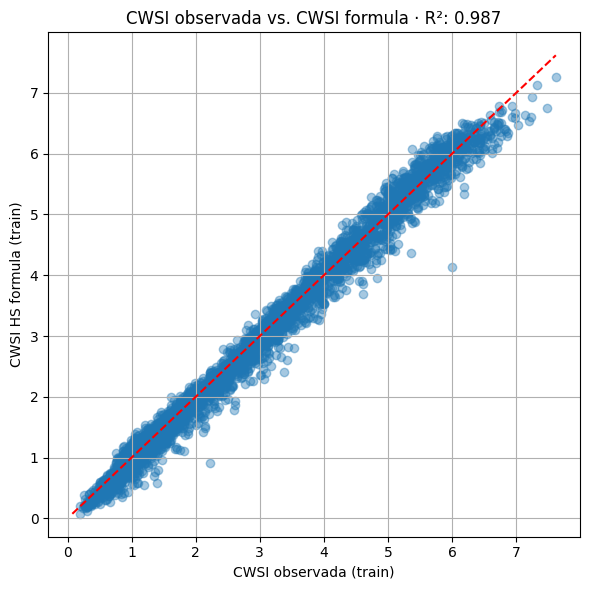

In [23]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Comparataiva dades reals amb dades físiques
rmse_hs_train = np.sqrt(mean_squared_error(y_train, ET0_PT_train_orig))
r2_hs_train   = r2_score(y_train, ET0_PT_train_orig)
r_hs_train = np.corrcoef(y_train, ET0_PT_train_orig)[0, 1]

print(f"RMSE HS (train): {rmse_hs_train:.3f} mm/dia")
print(f"R²   HS (train): {r2_hs_train:.3f}")
print(f"R    HS (train): {r_hs_train:.3f}")

# Comparació dades reals amb dades físiques.
plt.figure(figsize=(6,6))
plt.scatter(y_train, ET0_PT_train_orig, alpha=0.4)
mn = min(y_train.min(), ET0_PT_train_orig.min())
mx = max(y_train.max(), ET0_PT_train_orig.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("CWSI observada (train)")
plt.ylabel("CWSI HS formula (train)")
plt.title(f"CWSI observada vs. CWSI formula · R²: {r2_hs_train:.3f}")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Creació conjunts de dades combiants desde reals i dades de funció física
# Entrada a la funció de perdua
y_train_combined = np.hstack([y_train_scaled[:, np.newaxis], ET0_PT_train_scaled[:, np.newaxis]])
y_test_combined  = np.hstack([y_test_scaled[:, np.newaxis],  ET0_PT_test_scaled[:, np.newaxis]])

In [25]:
#Defineix de funcio p¡erdua per a calcular la perdude dades i fisica
def make_pinn_loss(theta=0.0):
    def pinn_loss(y_true_combined, y_pred):
         # Extracció dades
        y_data_scaled = tf.expand_dims(y_true_combined[:, 0], axis=1)
        y_phys_scaled = tf.expand_dims(y_true_combined[:, 1], axis=1)

        # Pèrdua de dades
        loss_data = tf.reduce_mean(tf.square(y_data_scaled - y_pred))

        # MSE de física
        loss_phys = tf.reduce_mean(tf.square(y_phys_scaled - y_pred))

        # Pèrdua total
        return (1.0 - theta) * loss_data + theta * loss_phys
    return pinn_loss

In [26]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate
from tensorflow.keras import regularizers

class SimplePINN(Model):
  # theta ponderancia de la funció física a la funció de perdua.
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Definir model
        self.dense1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.dropout1 = Dropout(0.4)
        self.dense2 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = inputs
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        return self.output_layer(x)

Entrenant amb θ = 0.0…
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
θ=0.0 → RMSE: 0.2145, R²: 0.9850, r: 0.9944
Entrenant amb θ = 0.1…
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
θ=0.1 → RMSE: 0.1888, R²: 0.9883, r: 0.9945
Entrenant amb θ = 0.2…
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
θ=0.2 → RMSE: 0.1829, R²: 0.9891, r: 0.9945
Entrenant amb θ = 0.3…
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
θ=0.3 → RMSE: 0.1936, R²: 0.9877, r: 0.9946
Entrenant amb θ = 0.4…
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
θ=0.4 → RMSE: 0.1844, R²: 0.9889, r: 0.9947
Entrenant amb θ = 0.5…
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
θ=0.5 → RMSE: 0.1826, R²: 0.9891, r: 0.9946
Entrenant amb θ = 0.6…
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
θ=0.6 → RMSE: 0.1896, R²: 0.9882, r: 0.9945
Entrenant amb θ = 0.7…
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
θ=0.7 → RMSE: 0.2115, R²: 0.9854, r: 0.9945
Entrenant amb θ = 0.8…
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
θ=0.8 → RMSE: 0.1907, R²: 0.9881, r: 0.9941
Entrenant amb θ = 0.9…
32/32 ━━━━━━━━━━━━━━━━━

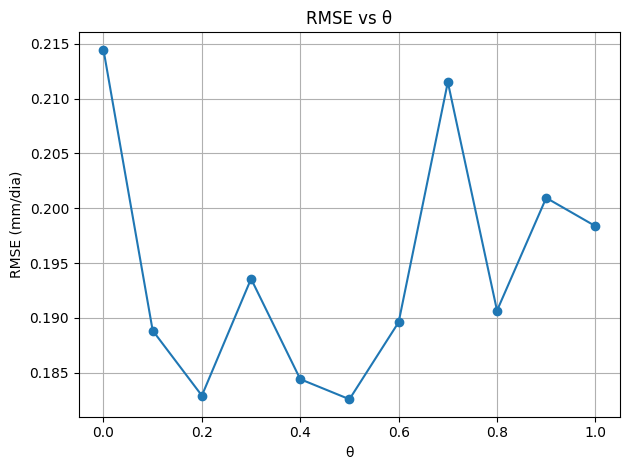

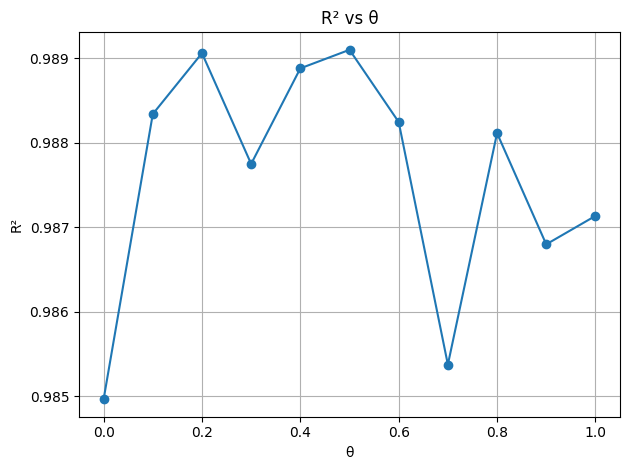

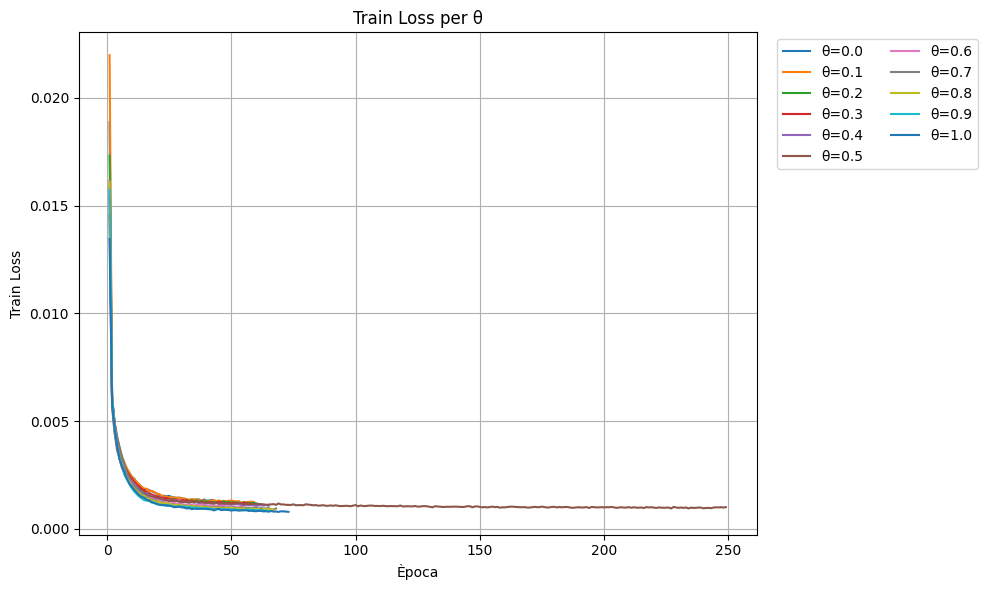

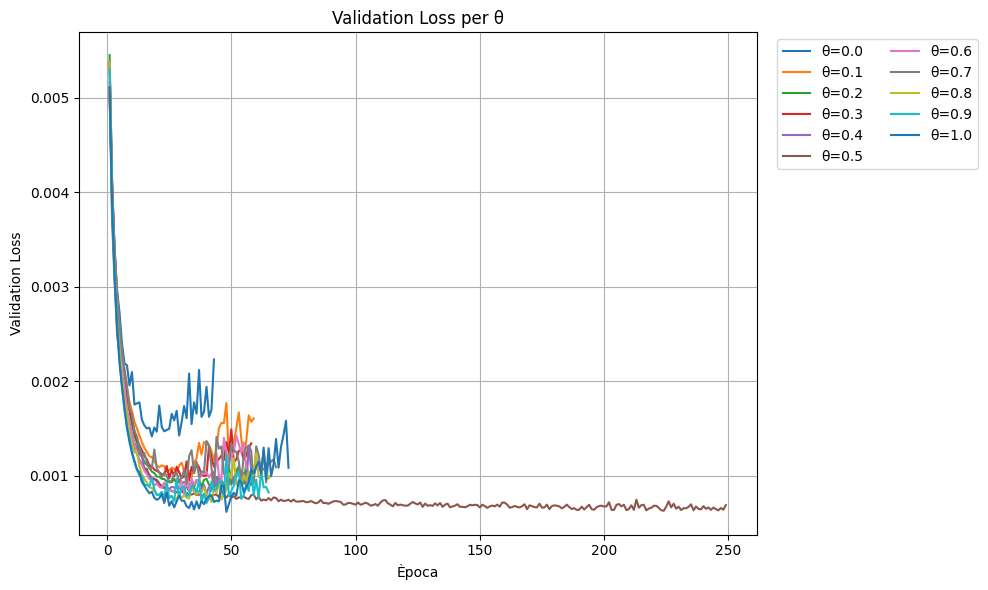

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Llista de thetas a provar
thetas = np.arange(0, 1.01, 0.1)

# Per emmagatzemar resultats
results = []

# PEr modelatge gràfiques de peèrdua
histories = {}

for theta in thetas:
    print(f"Entrenant amb θ = {theta:.1f}…")
    # Allibera memòria i crea un model net
    K.clear_session()

    # Defineix la funció de pèrdua i el model
    loss_fn = make_pinn_loss(theta=theta)
    model = SimplePINN()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=loss_fn,
        metrics=['mae']
        )

    # Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=25, restore_best_weights=True, verbose=0
    )

    # Entrenament
    history = model.fit(
        x=X_num_train_scaled,
        y=y_train_combined,
        validation_data=(X_num_test_scaled, y_test_combined),
        epochs=300, batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    histories[theta] = history.history

    # Predicció i avaluació
    y_pred_s = model.predict(X_num_test_scaled).flatten()
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
    y_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()

    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_val   = r2_score(y_true, y_pred)
    r_val    = np.corrcoef(y_true, y_pred)[0,1]

    print(f"θ={theta:.1f} → RMSE: {rmse_val:.4f}, R²: {r2_val:.4f}, r: {r_val:.4f}")

    results.append({
        'theta': theta,
        'rmse':  rmse_val,
        'r2':    r2_val,
        'r':     r_val
    })

# Converteix a DataFrame
df_res = pd.DataFrame(results)
print(df_res)

# Gràfic RMSE vs θ
plt.figure()
plt.plot(df_res['theta'], df_res['rmse'], marker='o')
plt.xlabel('θ')
plt.ylabel('RMSE (mm/dia)')
plt.title('RMSE vs θ')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gràfic R² vs θ
plt.figure()
plt.plot(df_res['theta'], df_res['r2'], marker='o')
plt.xlabel('θ')
plt.ylabel('R²')
plt.title('R² vs θ')
plt.grid(True)
plt.tight_layout()
plt.show()

# 1) Gràfic de Train Loss per a cada θ
plt.figure(figsize=(10,6))
for theta in thetas:
    h = histories[theta]
    epochs = range(1, len(h['loss'])+1)
    plt.plot(epochs, h['loss'], label=f'θ={theta:.1f}')
plt.xlabel('Època')
plt.ylabel('Train Loss')
plt.title('Train Loss per θ')
plt.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Gràfic de Val Loss per a cada θ
plt.figure(figsize=(10,6))
for theta in thetas:
    h = histories[theta]
    epochs = range(1, len(h['val_loss'])+1)
    plt.plot(epochs, h['val_loss'], label=f'θ={theta:.1f}')
plt.xlabel('Època')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per θ')
plt.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(model.summary())

Model: "simple_pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,301 (28.52 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,868 (19.02 KB)

None
